In [194]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import boxcox
from sklearn.metrics import f1_score, ConfusionMatrixDisplay,confusion_matrix
from catboost import CatBoostClassifier

from typing import Union


In [195]:
df = pd.read_csv('../data/raw/insurance_dataset.csv')
df = df.drop(axis = 1, labels=['ID']) #Deanonymization

In [196]:
test_df = pd.read_csv('../data/raw/test_set.csv')
test_df = test_df.drop(axis = 1, labels=['ID']) #Deanonymization

In [197]:
y = ['CLAIM?']
new_categorical = ['AGE', 'GENDER', 'DRIVING_EXPERIENCE', 'EDUCATION', 'VEHICLE_YEAR', 'INCOME', 'VEHICLE_TYPE', 'CLIENT LOCATION']
old_categorical = ['MARRIED', 'CHILDREN', 'VEHICLE_OWNERSHIP',]
drop = ['ID']
numerical = ['ANNUAL_MILEAGE', 'CREDIT_SCORE', 'SPEEDING_VIOLATIONS','PAST_ACCIDENTS', 'DUIS' ]

In [225]:
def feature_importance(features, model):
    for i,j in zip(features, model.get_feature_importance()):
        print(f"The importance of {i} is {j}")
    

def one_hot_encode(df, columns):
    """
    Encodes Categorical variables
    """
    
    for column in columns:
        temp_df = pd.get_dummies(df[column], prefix = column).astype(int)
        df = pd.concat([df, temp_df], axis = 1)
        df.drop(column, axis = 1, inplace = True)
    return df

def prep_test_df(train_features:list, test_df:pd.DataFrame) -> pd.DataFrame:
    
    """ Prepares a dataframe for testing, 
    Function checks if the columns are equal,
    amd adds/removes column names as required.
    """

    training_cols = train_features
    test_cols = test_df.columns.to_list()

    if len(set(training_cols).difference(test_cols)) > 0 :
        diff = set(training_cols).difference(test_cols)
        
        for x in diff:
            test_df[x] = 0

    return test_df[training_cols]

def evaluate(model, eval_df, eval_labels):
    
    """
    Evaluates a model performance on dataset,
    Input are  model, a dataframe, and labels
    """
    y_eval_pred = model.predict(eval_df)
    f1 = f1_score(y_eval_pred.tolist(), eval_labels)

    print("The f1 score is {}".format(f1))
    ConfusionMatrixDisplay.from_predictions(y_eval_pred, eval_labels)
    return f1


def check_wrong_predictions(pred_labels, eval_df, eval_labels)-> pd.DataFrame:
    
    """
    Checks wrong prediction of model on datapoints, in an attempt
    to analyse
    """
    indexes = []
    
    for index,(a,b) in enumerate(zip(pred_labels, eval_labels)):
        if a != b:
            indexes.append(index)
    
    print(indexes)
    temp_df = eval_df.iloc[indexes, :]

    temp_df['pred_label'] = a
    temp_df['correct_label'] = b

    return temp_df

def preproc_pipeline(df, target = Union[None, str]):

    ## add more preprocessing step
    df = one_hot_encode(df,new_categorical)

    labels = []
    if target and target in df.columns.to_list():
        labels = df[target]
        df.drop(columns= target, axis= 1, inplace= True)
    
    return df,labels 

def train(df:pd.DataFrame, model:CatBoostClassifier, features, remove= []):
    train, valid = train_test_split(df, test_size = 0.3, 
                                        stratify=df['CLIENT LOCATION'], 
                                        shuffle=True, random_state= 42)

    train_df,train_labels = preproc_pipeline(train[features],  target="CLAIM?")
    eval_df,eval_labels = preproc_pipeline(valid[features], target="CLAIM?")

    train_df.drop(columns= remove, axis=1 , inplace = True)
    eval_df.drop(columns= remove, axis=1 , inplace = True)

    model.fit(train_df,train_labels,use_best_model = True,
        eval_set = tuple((eval_df, eval_labels)),
            verbose = True)

    f1 = evaluate(model, eval_df, eval_labels)
    train_features = train_df.columns.to_list()
    
    feature_importance(train_features, model)
    return model, f1, train_features

Training machine learning model with only categorical variables and having specialised models for each age group

In [199]:
df['AGE'].unique()

array(['65+', '16-25', '26-39', '40-64'], dtype=object)

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9661 entries, 0 to 9660
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  9661 non-null   object 
 1   GENDER               9661 non-null   object 
 2   DRIVING_EXPERIENCE   9661 non-null   object 
 3   EDUCATION            9661 non-null   object 
 4   INCOME               9661 non-null   object 
 5   CREDIT_SCORE         8710 non-null   float64
 6   VEHICLE_OWNERSHIP    9661 non-null   int64  
 7   VEHICLE_YEAR         9661 non-null   object 
 8   MARRIED              9661 non-null   int64  
 9   CHILDREN             9661 non-null   int64  
 10  CLIENT LOCATION      9661 non-null   int64  
 11  ANNUAL_MILEAGE       8737 non-null   float64
 12  VEHICLE_TYPE         9661 non-null   object 
 13  SPEEDING_VIOLATIONS  9661 non-null   int64  
 14  DUIS                 9661 non-null   int64  
 15  PAST_ACCIDENTS       9661 non-null   i

In [201]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  339 non-null    object 
 1   GENDER               339 non-null    object 
 2   DRIVING_EXPERIENCE   339 non-null    object 
 3   EDUCATION            339 non-null    object 
 4   INCOME               339 non-null    object 
 5   CREDIT_SCORE         308 non-null    float64
 6   VEHICLE_OWNERSHIP    339 non-null    int64  
 7   VEHICLE_YEAR         339 non-null    object 
 8   MARRIED              339 non-null    int64  
 9   CHILDREN             339 non-null    int64  
 10  CLIENT LOCATION      339 non-null    int64  
 11  ANNUAL_MILEAGE       306 non-null    float64
 12  VEHICLE_TYPE         339 non-null    object 
 13  SPEEDING_VIOLATIONS  339 non-null    int64  
 14  DUIS                 339 non-null    int64  
 15  PAST_ACCIDENTS       339 non-null    int

## CREATING A MODEL FOR AGE_GROUP 16-25

In [202]:
millenial_df = df[df['AGE'] =='16-25']
millenial_df

,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,CLIENT LOCATION,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,CLAIM?
1,16-25,male,0-9y,none,poverty,0.357757,0,before 2015,0,0,10238,16000.0,sedan,0,0,0,1
2,16-25,female,0-9y,high school,working class,0.493146,1,before 2015,0,0,10238,11000.0,sedan,0,0,0,0
3,16-25,male,0-9y,university,working class,0.206013,1,before 2015,0,1,32765,11000.0,sedan,0,0,0,0
13,16-25,female,0-9y,university,upper class,0.591260,1,before 2015,0,1,10238,NaN,sedan,0,0,0,0
17,16-25,male,0-9y,none,poverty,NaN,0,before 2015,1,0,32765,12000.0,sedan,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9647,16-25,male,0-9y,high school,poverty,0.267472,0,before 2015,0,1,10238,13000.0,sedan,0,0,0,1
9651,16-25,female,0-9y,high school,poverty,0.277153,1,before 2015,1,0,21217,15000.0,sedan,0,0,0,1
9657,16-25,male,0-9y,university,poverty,0.489238,0,before 2015,1,1,10238,7000.0,sports car,0,0,0,1
9658,16-25,female,0-9y,university,working class,0.248632,0,before 2015,0,0,10238,11000.0,sedan,0,0,0,1


Using only categorical variables as features

In [203]:
model = CatBoostClassifier(learning_rate=0.02,
                           iterations=1000,
                           depth=10)

In [204]:
millenial_df.head()

,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,CLIENT LOCATION,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,CLAIM?
1,16-25,male,0-9y,none,poverty,0.357757,0,before 2015,0,0,10238,16000.0,sedan,0,0,0,1
2,16-25,female,0-9y,high school,working class,0.493146,1,before 2015,0,0,10238,11000.0,sedan,0,0,0,0
3,16-25,male,0-9y,university,working class,0.206013,1,before 2015,0,1,32765,11000.0,sedan,0,0,0,0
13,16-25,female,0-9y,university,upper class,0.591260,1,before 2015,0,1,10238,NaN,sedan,0,0,0,0
17,16-25,male,0-9y,none,poverty,NaN,0,before 2015,1,0,32765,12000.0,sedan,0,0,0,1


0:	learn: 0.6825732	test: 0.6821182	best: 0.6821182 (0)	total: 1.67ms	remaining: 1.67s
1:	learn: 0.6722749	test: 0.6714415	best: 0.6714415 (1)	total: 3.56ms	remaining: 1.78s
2:	learn: 0.6631837	test: 0.6617304	best: 0.6617304 (2)	total: 4.9ms	remaining: 1.63s
3:	learn: 0.6523511	test: 0.6513771	best: 0.6513771 (3)	total: 9.21ms	remaining: 2.29s
4:	learn: 0.6439688	test: 0.6425517	best: 0.6425517 (4)	total: 10.8ms	remaining: 2.15s
5:	learn: 0.6335283	test: 0.6324291	best: 0.6324291 (5)	total: 13.4ms	remaining: 2.22s
6:	learn: 0.6228458	test: 0.6242167	best: 0.6242167 (6)	total: 28.3ms	remaining: 4.02s
7:	learn: 0.6169718	test: 0.6179839	best: 0.6179839 (7)	total: 29.5ms	remaining: 3.65s
8:	learn: 0.6069425	test: 0.6105045	best: 0.6105045 (8)	total: 44.6ms	remaining: 4.91s
9:	learn: 0.5985104	test: 0.6028536	best: 0.6028536 (9)	total: 59.3ms	remaining: 5.87s
10:	learn: 0.5896434	test: 0.5956548	best: 0.5956548 (10)	total: 74.3ms	remaining: 6.68s
11:	learn: 0.5838304	test: 0.5891901	best:

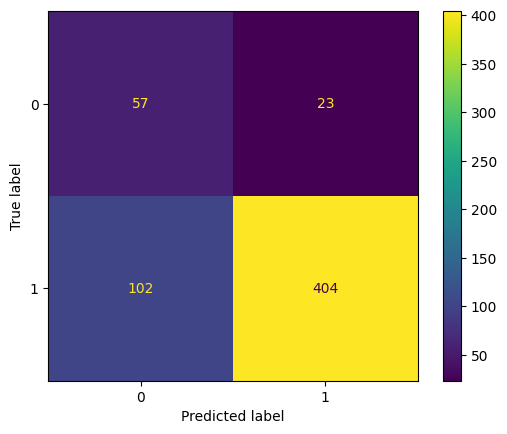

In [214]:
features = new_categorical + ['CLAIM?'] + old_categorical

model_age_16_25, f1_age_16_25, train_features = train(millenial_df, model, features)

### CHECK ON TEST SET

It can be observed that our model for the age group 16-25 predicts claims way more accurately than predicting than no claims. This confusion matrix shows that we can substantially rely on our model to predict which person within the age bracket of 16-25 who is likely to make a claim, but not one who won't make a claim

The f1 score is 0.8421052631578948


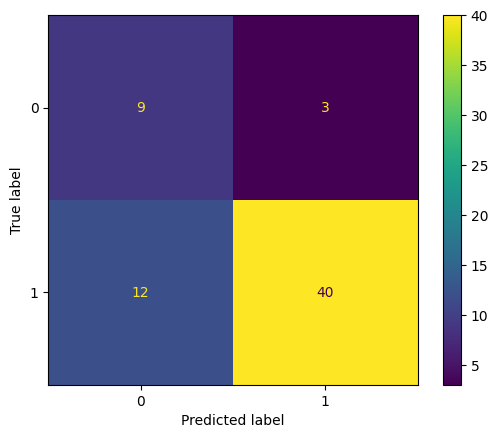

In [242]:
def check_on_test_set(df:pd.DataFrame, features, train_features:list, model):
    """
    Checks performance of a model on a dataframe or a slice of a dataframe
    Input: dataframe, and a list of features which correspond to what the model 
    was trained on
    """

    temp_test_df,true_labels = preproc_pipeline(df[features], target="CLAIM?")
    temp_test_df = prep_test_df(train_features, temp_test_df)
    pred_labels = model.predict(temp_test_df)
    evaluate(model, temp_test_df, pred_labels)
    
    return pred_labels, true_labels

df_16_25 = test_df[test_df['AGE'] == '16-25']
pred_labels, true_labels = check_on_test_set(df_16_25, features, train_features, model_age_16_25)

In [243]:
check_wrong_predictions(pred_labels, df_16_25, true_labels)

[]


,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,CLIENT LOCATION,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,CLAIM?,pred_label,correct_label


In [241]:
test_df[(test_df['AGE'] == '16-25') & (test_df['CLAIM?'] == 0)]

,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,CLIENT LOCATION,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,CLAIM?
0,16-25,male,0-9y,high school,poverty,0.150101,1,before 2015,0,0,10238,16000.0,sedan,0,0,0,0
13,16-25,male,0-9y,none,working class,0.397924,1,after 2015,0,1,10238,12000.0,sedan,0,0,0,0
20,16-25,female,0-9y,none,poverty,0.395962,1,before 2015,1,1,32765,10000.0,sedan,0,0,0,0
26,16-25,male,0-9y,high school,poverty,0.125896,0,after 2015,0,0,32765,14000.0,sedan,0,0,0,0
27,16-25,male,0-9y,university,working class,0.488063,1,before 2015,0,1,32765,10000.0,sedan,0,0,0,0
32,16-25,female,0-9y,high school,middle class,0.672216,1,after 2015,0,0,32765,17000.0,sedan,0,0,0,0
48,16-25,male,0-9y,none,working class,0.484096,1,before 2015,0,0,10238,15000.0,sedan,0,0,0,0
52,16-25,female,0-9y,university,upper class,NaN,1,after 2015,0,1,32765,10000.0,sedan,0,0,0,0
54,16-25,male,0-9y,university,upper class,0.572988,1,before 2015,1,0,10238,15000.0,sedan,0,0,0,0
64,16-25,male,0-9y,none,working class,0.485242,1,after 2015,1,0,10238,11000.0,sedan,0,0,0,0


In [134]:
feature_importance(train_features, model_age_16_25)

The importance of MARRIED is 4.986177524387878
The importance of CHILDREN is 5.624004650394223
The importance of VEHICLE_OWNERSHIP is 27.67753243902876
The importance of AGE_16-25 is 0.0
The importance of GENDER_female is 6.241455967325563
The importance of GENDER_male is 8.829653213037457
The importance of DRIVING_EXPERIENCE_0-9y is 0.0
The importance of EDUCATION_high school is 3.7294050350561414
The importance of EDUCATION_none is 1.3548154788310907
The importance of EDUCATION_university is 2.2416731287749894
The importance of VEHICLE_YEAR_after 2015 is 9.920517325991069
The importance of VEHICLE_YEAR_before 2015 is 7.559147728775932
The importance of INCOME_middle class is 2.5807755675326858
The importance of INCOME_poverty is 2.4941965066194776
The importance of INCOME_upper class is 0.8520542147117386
The importance of INCOME_working class is 3.6644108407804805
The importance of VEHICLE_TYPE_sedan is 0.5894738566908367
The importance of VEHICLE_TYPE_sports car is 1.02460889197696

In [135]:
model.save_model('../models/model_age_16_25.json', format= 'json')